Cfd vs underlying assset <br> by Anatolii Frolov

Let's explore all the points we need to adress in this project: 
1. We need to scoop up the data
    1. BTC/USD data with the 1s delays 
        - It's easy but requires the api key ( it was ruined , so just downloaded it)
    2. BTC/USD cfd data from dukascopy brokerage
        - Here we needed to adress the problem of max one day data extraction
            - It's solved by a library that was written by one guy https://github.com/algogenetic/dukascopy-1
2. We need to convert with pct_change to be not iid but to contain that sweet mean-reversion that we need 
3. We need to adress the problem of CFD been traded on Swiss trading hours 
    1. We can use the unused hours to calculate the volatility for period using variation of garch(preferably t-garch as I want this to be riskless strategy with initial payoff of zero)
    2. We can just delete the extra(unused hours)
4. We need to introduce the points of entry for the model and exits
    - Rsi for example (implementation in the document)
    - MACD https://www.quantifiedstrategies.com/python-and-macd-trading-strategy/
    - ATR https://www.quantifiedstrategies.com/average-true-range-trading-strategy-in-python/
5. Teaching the regression on best combo of this two ways of buying -> setting up weights
6. Backtesting the model on 2018 - 2021
7. Results 
        

# Data

## Dukascopy

In [211]:
import numpy as np
import pandas as pd

In [212]:
import importlib
try:
    dukascopy = importlib.import_module('dukascopy')
    print("Module imported successfully!")
except ImportError as e:
    print(f"ImportError: {e}")

Module imported successfully!


Fun fact this packagewas stolen from the user guise88, his original package works way better, im going to show you
- It's only terminal package and requires some skills to it
- You can directly install it by typing pip install duka
- then write duka -h , to get some help

Quick update: I spent several hours rewriting the package and got NOTHING from it, I could've done myself way faster, the reaseon is the error that i get, maybe it's related to cookies or,as i think, this: </br> File "/Users/anatoliifrolov/Desktop/machete/venv/lib/python3.10/site-packages/duka/core/fetch.py", line 38, in get
    raise Exception("Request failed for {0} after ATTEMPTS attempts".format(url))
Exception: Request failed for https://www.dukascopy.com/datafeed/BTCUSD/2019/00/20/23h_ticks.bi5 after ATTEMPTS attempts

The link is broken beyond repair and the code in repo is not readable for me so i guess i have to merge the data manually </br> how cool is that, moreover, now i can't do 1s ticks, so everything is ruined! Hooray, now, my project is not ideal 


In [213]:
data1 = pd.read_csv('d1.csv')

In [214]:
data2 = pd.read_csv('d2.csv')

In [215]:
data3 = pd.read_csv('d3.csv')

Only have the data fromthe creation of cfd : 2017-05-31

In [216]:
data_cfd = pd.concat([data1,data2,data3])

In [217]:
data_cfd # everything looks right, just need to reset the index

,Gmt time,Open,High,Low,Close,Volume
0,31.05.2017 00:00:00.000,2191,2203,2188,2189,2.1260
1,31.05.2017 00:01:00.000,2190,2198,2189,2198,3.2553
2,31.05.2017 00:02:00.000,2198,2198,2184,2191,2.7114
3,31.05.2017 00:03:00.000,2192,2192,2186,2188,1.8737
4,31.05.2017 00:04:00.000,2188,2205,2184,2188,2.3516
...,...,...,...,...,...,...
1363675,01.01.2025 23:55:00.000,94361,94365,94351,94363,0.0002
1363676,01.01.2025 23:56:00.000,94365,94402,94363,94402,0.0001
1363677,01.01.2025 23:57:00.000,94402,94426,94402,94417,0.0002
1363678,01.01.2025 23:58:00.000,94412,94412,94382,94382,0.0002


In [218]:
data_cfd = data_cfd.reset_index(drop = True,inplace =False)

In [219]:
data_cfd

,Gmt time,Open,High,Low,Close,Volume
0,31.05.2017 00:00:00.000,2191,2203,2188,2189,2.1260
1,31.05.2017 00:01:00.000,2190,2198,2189,2198,3.2553
2,31.05.2017 00:02:00.000,2198,2198,2184,2191,2.7114
3,31.05.2017 00:03:00.000,2192,2192,2186,2188,1.8737
4,31.05.2017 00:04:00.000,2188,2205,2184,2188,2.3516
...,...,...,...,...,...,...
3956657,01.01.2025 23:55:00.000,94361,94365,94351,94363,0.0002
3956658,01.01.2025 23:56:00.000,94365,94402,94363,94402,0.0001
3956659,01.01.2025 23:57:00.000,94402,94426,94402,94417,0.0002
3956660,01.01.2025 23:58:00.000,94412,94412,94382,94382,0.0002


In [220]:
data_cfd['Gmt time'] = pd.to_datetime(data_cfd['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')


In [221]:
data_cfd.head()

,Gmt time,Open,High,Low,Close,Volume
0,2017-05-31 00:00:00,2191,2203,2188,2189,2.1260
1,2017-05-31 00:01:00,2190,2198,2189,2198,3.2553
2,2017-05-31 00:02:00,2198,2198,2184,2191,2.7114
3,2017-05-31 00:03:00,2192,2192,2186,2188,1.8737
4,2017-05-31 00:04:00,2188,2205,2184,2188,2.3516


## BTCdata


In [222]:
import yfinance as yf
from yfinance import Ticker

In [223]:
BTC = yf.Ticker('BTC-USD')

In [224]:
st = '2017-05-31'
end = '2025-01-26'

In [225]:
BTC.history(start =st, end = end, interval = '1m' )

$BTC-USD: possibly delisted; no price data found  (1m 2017-05-31 -> 2025-01-26) (Yahoo error = "1m data not available for startTime=1496188800 and endTime=1737849600. Only 8 days worth of 1m granularity data are allowed to be fetched per request.")


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


HOW COOL IS THAT THEY TOO HAVE A PROBLEM WITH DATA))))))

In [226]:
# i just stole it from here https://www.kaggle.com/datasets/imranbukhari/comprehensive-btcusd-1m-data?resource=download
data_btc = pd.read_csv('d4.csv')

In [227]:
data_btc.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:59.999,7564.906851,3.0,0.075183,320.390851,0.0
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:01:59.999,0.000000,0.0,0.000000,0.000000,0.0
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,2017-08-17 04:02:59.999,1117.542921,2.0,0.261074,1117.542921,0.0
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,2017-08-17 04:03:59.999,51.171852,3.0,0.012008,51.171852,0.0
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,2017-08-17 04:04:59.999,599.999338,1.0,0.140796,599.999338,0.0


Now, i will cut the data to start from "2017-08-17 04:00:00"

And btc one to end at"2025-01-01 23:59:00"

In [228]:
data_btc['Open time'].dtype

dtype('O')

In [229]:
data_btc['Open time'] = pd.to_datetime(data_btc['Open time'])


In [230]:
# data_btc['Open time'] = pd.to_datetime(data_btc['Open time'], format='%d.%m.%Y %H:%M:%S.%f')


### Data cutting

In [231]:
data_cfd.head()

,Gmt time,Open,High,Low,Close,Volume
0,2017-05-31 00:00:00,2191,2203,2188,2189,2.1260
1,2017-05-31 00:01:00,2190,2198,2189,2198,3.2553
2,2017-05-31 00:02:00,2198,2198,2184,2191,2.7114
3,2017-05-31 00:03:00,2192,2192,2186,2188,1.8737
4,2017-05-31 00:04:00,2188,2205,2184,2188,2.3516


In [232]:
filtered_df_cfd = data_cfd[data_cfd['Gmt time'] > pd.to_datetime('2017-08-17 03:59:00')]


In [233]:
filtered_df_cfd.head()

,Gmt time,Open,High,Low,Close,Volume
112560,2017-08-17 04:00:00,4280,4287,4280,4280,0.3669
112561,2017-08-17 04:01:00,4280,4287,4280,4280,0.4473
112562,2017-08-17 04:02:00,4280,4280,4270,4271,1.5517
112563,2017-08-17 04:03:00,4271,4271,4270,4271,0.5356
112564,2017-08-17 04:04:00,4271,4280,4271,4273,3.5479


In [234]:
filtered_df_btc = data_btc[data_btc['Open time'] < pd.to_datetime('2025-01-02 00:00:00')]


In [235]:
filtered_df_btc.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:59.999,7564.906851,3.0,0.075183,320.390851,0.0
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:01:59.999,0.000000,0.0,0.000000,0.000000,0.0
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,2017-08-17 04:02:59.999,1117.542921,2.0,0.261074,1117.542921,0.0
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,2017-08-17 04:03:59.999,51.171852,3.0,0.012008,51.171852,0.0
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,2017-08-17 04:04:59.999,599.999338,1.0,0.140796,599.999338,0.0


In [236]:
filtered_df_cfd.tail()

,Gmt time,Open,High,Low,Close,Volume
3956657,2025-01-01 23:55:00,94361,94365,94351,94363,0.0002
3956658,2025-01-01 23:56:00,94365,94402,94363,94402,0.0001
3956659,2025-01-01 23:57:00,94402,94426,94402,94417,0.0002
3956660,2025-01-01 23:58:00,94412,94412,94382,94382,0.0002
3956661,2025-01-01 23:59:00,94379,94407,94344,94350,0.0003


In [237]:
filtered_df_btc.tail()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
3871923,2025-01-01 23:55:00,94601.28,94609.47,94596.82,94609.47,1.94623,2025-01-01 23:55:59.999,184122.707427,518.0,1.27625,120738.708672,0.0
3871924,2025-01-01 23:56:00,94609.47,94643.26,94609.46,94643.26,4.44622,2025-01-01 23:56:59.999,420743.532628,622.0,4.14952,392669.309007,0.0
3871925,2025-01-01 23:57:00,94643.25,94665.22,94642.43,94642.43,4.90859,2025-01-01 23:57:59.999,464636.574822,1624.0,1.38741,131321.559863,0.0
3871926,2025-01-01 23:58:00,94642.43,94642.44,94605.51,94605.51,8.29700,2025-01-01 23:58:59.999,785162.831748,1254.0,0.98798,93492.584192,0.0
3871927,2025-01-01 23:59:00,94605.52,94605.52,94591.21,94591.79,9.05069,2025-01-01 23:59:59.999,856181.137371,679.0,5.63995,533522.703301,0.0


In [238]:
len(filtered_df_cfd)

3844102

In [239]:
len(filtered_df_btc)

3871928

In [240]:
cfd = filtered_df_cfd.reset_index()
btc = filtered_df_btc.reset_index()

It's another problem , as online trading markets are open for a certain time, we need to account for that 

But there is something good, that is if we do the correlation matrix, we would get exactly 1, </br> therefore , we would need to the calls to buy and sell for cfd and do the opposite for btc

Let's look at the graph before doing anything to the data

In [241]:
import matplotlib.pyplot as plt

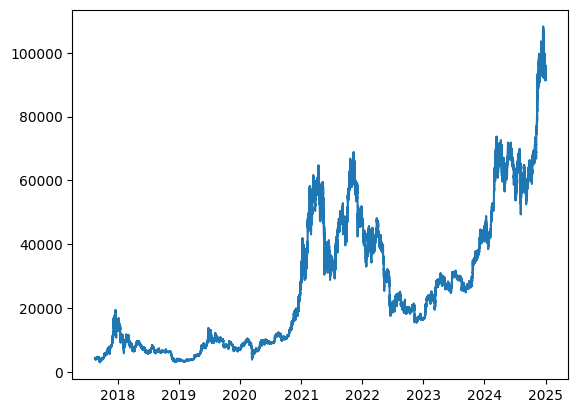

In [242]:
plt.plot(cfd['Gmt time'], cfd['Close'])

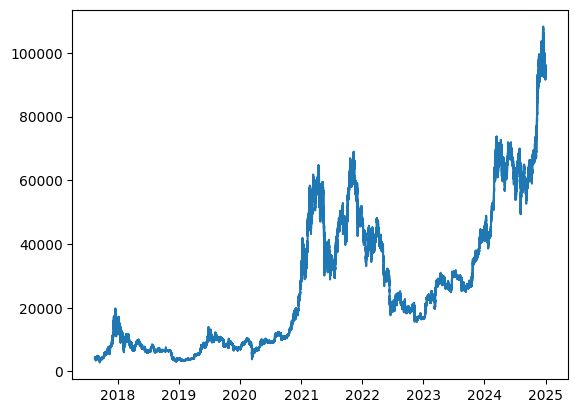

In [243]:
plt.plot(btc['Open time'], btc['Close'])

Now, on the same graph

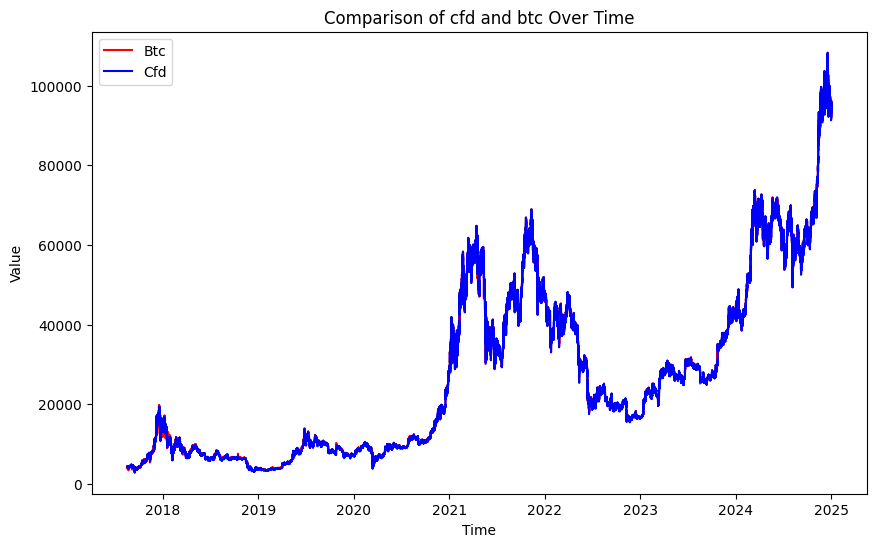

In [244]:
plt.figure(figsize=(10, 6))
plt.plot(btc['Open time'], btc['Close'], color='red', label='Btc')

plt.plot(cfd['Gmt time'], cfd['Close'], color='blue', alpha = 1 ,label='Cfd')


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of cfd and btc Over Time')
plt.legend()
plt.show()

Now, we will zoom im

/Users/anatoliifrolov/Desktop/machete/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


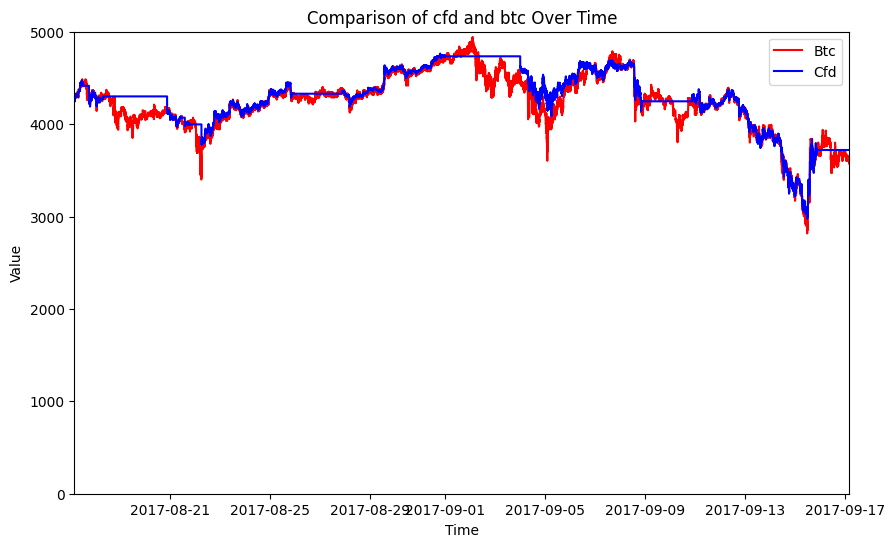

In [245]:
plt.figure(figsize=(10, 6))
plt.plot(btc['Open time'], btc['Close'], color='red', label='Btc')

plt.plot(cfd['Gmt time'], cfd['Close'], color='blue', alpha = 1 ,label='Cfd')
plt.xlim(pd.to_datetime('2017-08-17 04:01:00'), pd.to_datetime('2017-9-17 04:03:00'))
plt.ylim(0, 5000)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of cfd and btc Over Time')
plt.legend()
plt.show()

Hooray, the picture is setting in
- It's better to long cfd and short btc

Let's check other dates

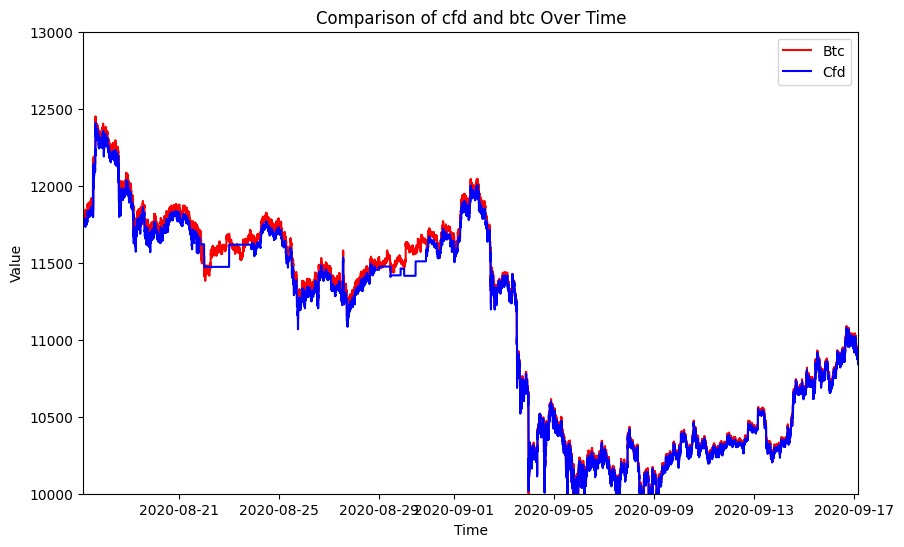

In [246]:
plt.figure(figsize=(10, 6))
plt.plot(btc['Open time'], btc['Close'], color='red', label='Btc')

plt.plot(cfd['Gmt time'], cfd['Close'], color='blue', alpha = 1 ,label='Cfd')
plt.xlim(pd.to_datetime('2020-08-17 04:01:00'), pd.to_datetime('2020-9-17 04:01:00'))
plt.ylim(10000, 13000)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of cfd and btc Over Time')
plt.legend()
plt.show()

Now, the situation has changed, we can see the worsening!
- the margin between two assets is closing in
- now is better to long btc and short cfd

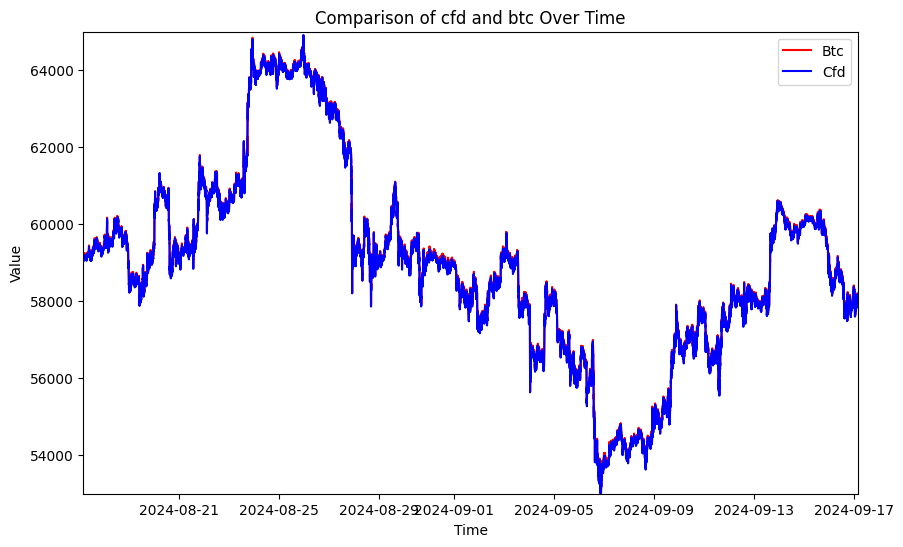

In [247]:
plt.figure(figsize=(10, 6))
plt.plot(btc['Open time'], btc['Close'], color='red', label='Btc')

plt.plot(cfd['Gmt time'], cfd['Close'], color='blue', alpha = 1 ,label='Cfd')
plt.xlim(pd.to_datetime('2024-08-17 04:01:00'), pd.to_datetime('2024-9-17 04:01:00'))
plt.ylim(53000, 65000)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Comparison of cfd and btc Over Time')
plt.legend()
plt.show()

We can see that the margin has almost closed between two assets

## Tweaking the names

In [248]:
cfd.columns

Index(['index', 'Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [249]:
cfd.columns = ['cfd_' + col for col in cfd.columns]


In [250]:
cfd.columns

Index(['cfd_index', 'cfd_Gmt time', 'cfd_Open', 'cfd_High', 'cfd_Low',
       'cfd_Close', 'cfd_Volume'],
      dtype='object')

In [251]:
btc.columns

Index(['index', 'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Close time', 'Quote asset volume', 'Number of trades',
       'Taker buy base asset volume', 'Taker buy quote asset volume',
       'Ignore'],
      dtype='object')

In [252]:
btc.columns = ['btc' + col for col in btc.columns]

In [253]:
btc.columns

Index(['btcindex', 'btcOpen time', 'btcOpen', 'btcHigh', 'btcLow', 'btcClose',
       'btcVolume', 'btcClose time', 'btcQuote asset volume',
       'btcNumber of trades', 'btcTaker buy base asset volume',
       'btcTaker buy quote asset volume', 'btcIgnore'],
      dtype='object')

# I need to adress the change in the dominating strategy 

It's super non -obvious to me and i won't lie, i can onlythink of one thing: volume ? let's check it

In [254]:
#pd.to_datetime('2017-08-17 04:01:00'), pd.to_datetime('2017-9-17 04:03:00')
filtered_df = cfd[(cfd['cfd_Gmt time'] >= '2017-08-17 04:01:00') & (cfd['cfd_Gmt time'] <= '2017-9-17 04:03:00')]
filtered_df['cfd_Volume'].mean()

np.float64(1.068263344757297)

In [255]:
filtered_df = btc[(btc['btcOpen time'] >= '2017-08-17 04:01:00') & (btc['btcOpen time'] <= '2017-9-17 04:03:00')]
filtered_df['btcVolume'].mean()

np.float64(0.5908253749547757)

volume won't tell us a thing, that's sad, because fees are more in cfd as i remember

Let's exclude rows that are not-needed(not that they are not needed, i just won't perform any k-fold with trees because there is no need , my strategy is not straight-forward,might do it later if requirements are not met)

In [256]:
# btc = btc[btc['btcOpen time'].isin(cfd['cfd_Gmt time'])]


In [257]:
len(btc),len(cfd)

(3871928, 3844102)

In [258]:
btc.head()

,btcindex,btcOpen time,btcOpen,btcHigh,btcLow,btcClose,btcVolume,btcClose time,btcQuote asset volume,btcNumber of trades,btcTaker buy base asset volume,btcTaker buy quote asset volume,btcIgnore
0,0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:59.999,7564.906851,3.0,0.075183,320.390851,0.0
1,1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:01:59.999,0.000000,0.0,0.000000,0.000000,0.0
2,2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,2017-08-17 04:02:59.999,1117.542921,2.0,0.261074,1117.542921,0.0
3,3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,2017-08-17 04:03:59.999,51.171852,3.0,0.012008,51.171852,0.0
4,4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,2017-08-17 04:04:59.999,599.999338,1.0,0.140796,599.999338,0.0


In [259]:
cfd.head()

,cfd_index,cfd_Gmt time,cfd_Open,cfd_High,cfd_Low,cfd_Close,cfd_Volume
0,112560,2017-08-17 04:00:00,4280,4287,4280,4280,0.3669
1,112561,2017-08-17 04:01:00,4280,4287,4280,4280,0.4473
2,112562,2017-08-17 04:02:00,4280,4280,4270,4271,1.5517
3,112563,2017-08-17 04:03:00,4271,4271,4270,4271,0.5356
4,112564,2017-08-17 04:04:00,4271,4280,4271,4273,3.5479


In [260]:
excluded_mask = ~btc['btcOpen time'].isin(cfd['cfd_Gmt time'])

filtered_df_btc = btc[~excluded_mask]

# Step 3: Get the excluded rows
excluded_df = btc[excluded_mask]
excluded_df

,btcindex,btcOpen time,btcOpen,btcHigh,btcLow,btcClose,btcVolume,btcClose time,btcQuote asset volume,btcNumber of trades,btcTaker buy base asset volume,btcTaker buy quote asset volume,btcIgnore
563229,563229,2018-09-15 00:00:00,6476.63,6482.63,6475.00,6475.00,18.454718,2018-09-15 00:00:59.999,119541.983351,185.0,7.112871,46086.369075,0.0
563230,563230,2018-09-15 00:01:00,6475.12,6480.87,6473.30,6480.86,26.761588,2018-09-15 00:01:59.999,173275.408195,153.0,14.845240,96123.077713,0.0
563231,563231,2018-09-15 00:02:00,6480.86,6488.88,6477.30,6484.00,7.756163,2018-09-15 00:02:59.999,50276.931527,90.0,4.950497,32094.153403,0.0
563232,563232,2018-09-15 00:03:00,6484.03,6491.98,6484.03,6486.27,10.519554,2018-09-15 00:03:59.999,68246.347852,90.0,4.371192,28358.426695,0.0
563233,563233,2018-09-15 00:04:00,6489.99,6492.00,6486.27,6488.82,21.215270,2018-09-15 00:04:59.999,137667.805224,68.0,9.178617,59576.720196,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241950,1241950,2019-12-31 23:55:00,7204.25,7206.29,7203.28,7205.90,5.358492,2019-12-31 23:55:59.999,38606.854134,106.0,3.015010,21722.902450,0.0
1241951,1241951,2019-12-31 23:56:00,7205.88,7205.90,7192.06,7194.08,50.279127,2019-12-31 23:56:59.999,361978.656589,317.0,3.188448,22963.751210,0.0
1241952,1241952,2019-12-31 23:57:00,7193.80,7196.04,7190.17,7190.17,11.425707,2019-12-31 23:57:59.999,82185.038824,149.0,4.154152,29881.805031,0.0
1241953,1241953,2019-12-31 23:58:00,7190.79,7196.07,7190.79,7195.87,4.488904,2019-12-31 23:58:59.999,32290.752109,137.0,2.621534,18858.415785,0.0


All non-trading time

In [261]:
len(filtered_df_btc) , len(cfd)

(3832713, 3844102)

Now, we will do the same for the btc, as it was too non-tradeable for some time


In [262]:
excluded_mask = ~cfd['cfd_Gmt time'].isin(btc['btcOpen time'])

filtered_df_cfd = cfd[~excluded_mask]

# Step 3: Get the excluded rows
excluded_df = cfd[excluded_mask]
excluded_df

,cfd_index,cfd_Gmt time,cfd_Open,cfd_High,cfd_Low,cfd_Close,cfd_Volume
29521,142081,2017-09-06 16:01:00,4673,4679,4652,4667,2.0682
29522,142082,2017-09-06 16:02:00,4667,4667,4646,4666,5.4285
29523,142083,2017-09-06 16:03:00,4666,4669,4665,4669,4.6243
29524,142084,2017-09-06 16:04:00,4665,4666,4664,4665,2.8204
29525,142085,2017-09-06 16:05:00,4665,4666,4644,4666,3.1348
...,...,...,...,...,...,...,...
2908937,3021497,2023-03-24 13:55:00,27912,27985,27912,27937,0.0018
2908938,3021498,2023-03-24 13:56:00,27937,27939,27901,27903,0.0004
2908939,3021499,2023-03-24 13:57:00,27903,27935,27884,27906,0.0016
2908940,3021500,2023-03-24 13:58:00,27906,27913,27897,27902,0.0005


In [263]:
len(filtered_df_btc) , len(filtered_df_cfd) # still no the same, i will use the sacred left-join then

(3832713, 3835593)

In [264]:
lj = pd.merge(filtered_df_btc, filtered_df_cfd, left_on='btcOpen time', right_on='cfd_Gmt time', how='left')


In [265]:
lj.head()

,btcindex,btcOpen time,btcOpen,btcHigh,btcLow,btcClose,btcVolume,btcClose time,btcQuote asset volume,btcNumber of trades,btcTaker buy base asset volume,btcTaker buy quote asset volume,btcIgnore,cfd_index,cfd_Gmt time,cfd_Open,cfd_High,cfd_Low,cfd_Close,cfd_Volume
0,0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:59.999,7564.906851,3.0,0.075183,320.390851,0.0,112560,2017-08-17 04:00:00,4280,4287,4280,4280,0.3669
1,1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:01:59.999,0.000000,0.0,0.000000,0.000000,0.0,112561,2017-08-17 04:01:00,4280,4287,4280,4280,0.4473
2,2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,2017-08-17 04:02:59.999,1117.542921,2.0,0.261074,1117.542921,0.0,112562,2017-08-17 04:02:00,4280,4280,4270,4271,1.5517
3,3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,2017-08-17 04:03:59.999,51.171852,3.0,0.012008,51.171852,0.0,112563,2017-08-17 04:03:00,4271,4271,4270,4271,0.5356
4,4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,2017-08-17 04:04:59.999,599.999338,1.0,0.140796,599.999338,0.0,112564,2017-08-17 04:04:00,4271,4280,4271,4273,3.5479


In [266]:
lj1 = lj.copy() # just for direction and inner id purposes... , plus it's left for probable changes for estimation of coefficients

In [267]:
lj1 = lj1.drop(columns = ['btcindex',  'btcOpen', 'btcHigh', 'btcLow', 
       'btcVolume', 'btcClose time', 'btcQuote asset volume',
       'btcNumber of trades', 'btcTaker buy base asset volume',
       'btcTaker buy quote asset volume', 'btcIgnore', 'cfd_index',
        'cfd_Open', 'cfd_High', 'cfd_Low',
       'cfd_Volume'])

In [268]:
lj1.head()

,btcOpen time,btcClose,cfd_Gmt time,cfd_Close
0,2017-08-17 04:00:00,4261.48,2017-08-17 04:00:00,4280
1,2017-08-17 04:01:00,4261.48,2017-08-17 04:01:00,4280
2,2017-08-17 04:02:00,4280.56,2017-08-17 04:02:00,4271
3,2017-08-17 04:03:00,4261.48,2017-08-17 04:03:00,4271
4,2017-08-17 04:04:00,4261.48,2017-08-17 04:04:00,4273


In [269]:
lj1['Cfd1'] = (lj1['btcClose'] < lj1['cfd_Close']).astype(int)

In [270]:
lj1.head()

,btcOpen time,btcClose,cfd_Gmt time,cfd_Close,Cfd1
0,2017-08-17 04:00:00,4261.48,2017-08-17 04:00:00,4280,1
1,2017-08-17 04:01:00,4261.48,2017-08-17 04:01:00,4280,1
2,2017-08-17 04:02:00,4280.56,2017-08-17 04:02:00,4271,0
3,2017-08-17 04:03:00,4261.48,2017-08-17 04:03:00,4271,1
4,2017-08-17 04:04:00,4261.48,2017-08-17 04:04:00,4273,1


In [271]:
lj1 = lj1.rename(columns = {'btcOpen time' : 'time'})

In [272]:
lj1['Cfd1'].sum()/len(lj1) # on;y 11 percent , so i consider that 89 percent of time , it's either more or the same 

np.float64(0.11836422686140056)

In [273]:
from datetime import datetime, timedelta


In [274]:
def interval(df,series,  start):
    end = pd.to_datetime(start) + timedelta(days =15) 
    return df[(df[series] > start) & (df[series] < end)]


In [275]:
# pd.to_datetime('2019-01-01') + timedelta(days)

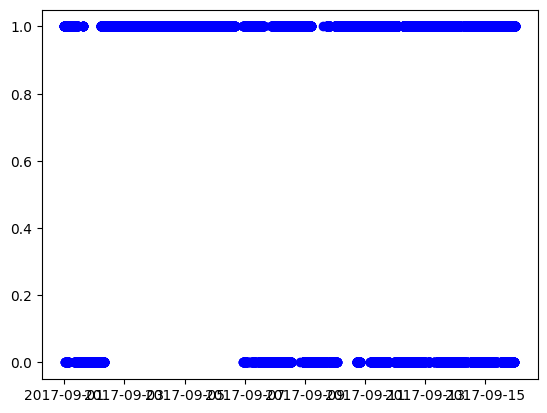

In [276]:
plt.step(interval(lj1, "time",'2017-09-01')['time'],interval(lj1, "time",'2017-09-01')['Cfd1'], 'bo')
# plt.ylim(0.95,2)

I suppose that cfd > btc only in 2017 </br> Let's check it

In [277]:
# pd.to_datetime(lj1['time']).year

In [278]:
lj1['year'] = lj1['time'].dt.year

# Step 3: Group by year and sum the boolean feature
yearly_sum = lj1.groupby('year')['Cfd1'].sum().reset_index()

In [279]:
yearly_sum

,year,Cfd1
0,2017,128094
1,2018,49530
2,2019,34888
3,2020,42279
4,2021,105072
5,2022,16867
6,2023,22525
7,2024,53897
8,2025,845


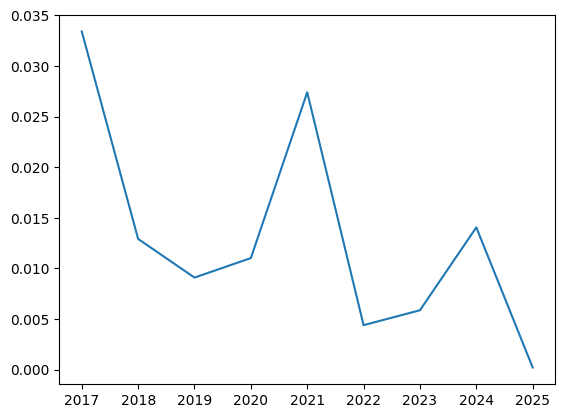

In [280]:
plt.plot(yearly_sum['year'] , yearly_sum['Cfd1']/len(lj1)) # never goes over 3.5 %

# Pct_change

In [281]:
lj1['diff'] = lj1['cfd_Close'] - lj1['btcClose']
lj1['diff_pct'] = (lj1['cfd_Close'] - lj1['btcClose']).pct_change()


In [282]:
lj1['btcClose'] = lj1['btcClose'].pct_change()

In [283]:
lj1['cfd_Close'] = lj1['cfd_Close'].pct_change()

now, they-are are at least stationary, this would've been useful for linear regression

## Plotting differenct

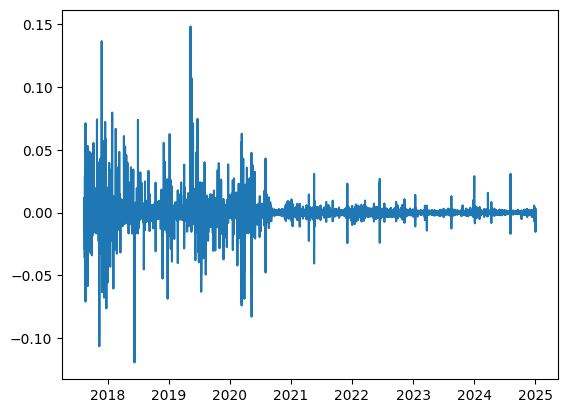

In [284]:
plt.plot(lj1['time'], lj1['cfd_Close'] - lj1['btcClose'] ) # IT OSCILLATEEEEES! good looking distribtion

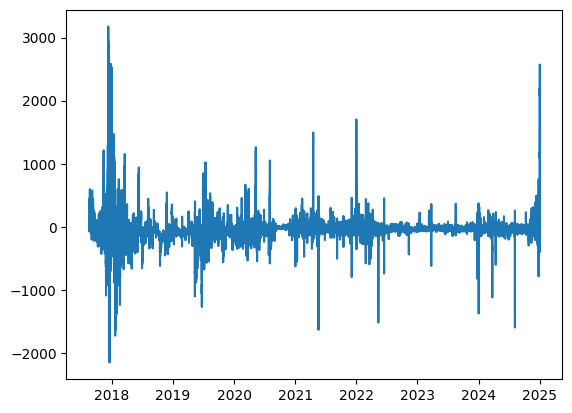

In [285]:
plt.plot(lj1['time'], lj1['diff'] ) #  i can't grasp the concept , but how you take the difference decides the way of the movement

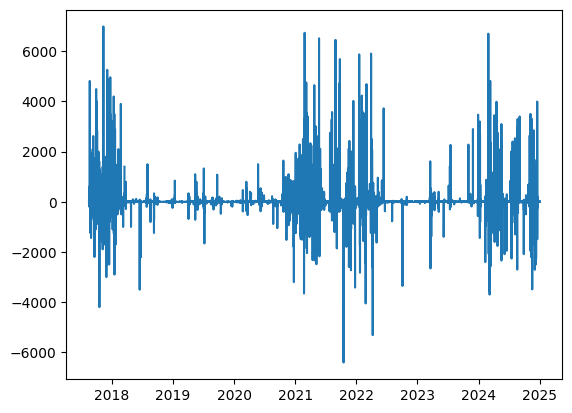

In [286]:
plt.plot(lj1['time'], lj1['diff_pct']) # IT OSCILLATEEEEES! good looking distribtion

Small rant: 
- I've spent a lot of time on this project and i see literally no difference in the cost -> no profit to be made starting from the mid 2020 </br> depending on which side you are on

# Coding entries

vectorbt just doesn;t work:)

In [ ]:
# rsi = vbt.RSI.run(lj1.btcClose, window=14)
# entries = rsi.rsi_crossed_below(30)
# exits = rsi.rsi_crossed_above(80)
# btc_pf = vbt.Portfolio.from_signals(btc.Close, entries, exits)

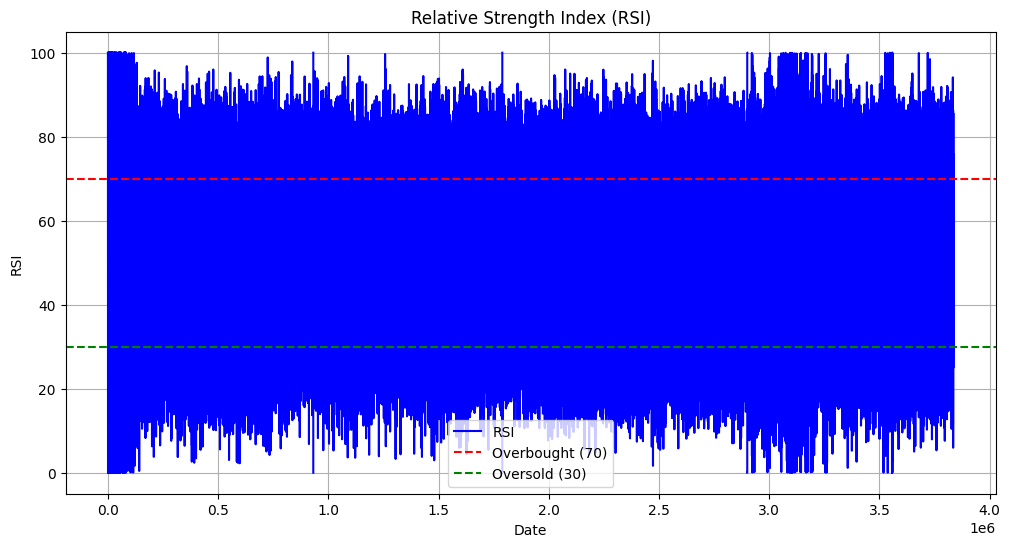

             btcClose        RSI
3835573  1.056814e-07  36.601806
3835574  5.479582e-04  42.429869
3835575  3.610213e-04  47.854942
3835576  6.292892e-05  47.854458
3835577  1.691372e-04  53.232273
3835578  1.266731e-04  52.856787
3835579 -1.213797e-05  52.656649
3835580  1.435464e-05  52.112852
3835581 -5.662615e-04  51.841861
3835582 -5.030068e-04  48.510472
3835583 -2.212526e-04  48.746624
3835584 -2.196107e-04  48.268453
3835585  4.259987e-05  45.554483
3835586 -1.217691e-04  47.271536
3835587  7.970930e-05  47.209430
3835588  8.667960e-05  48.123725
3835589  3.571524e-04  48.880307
3835590 -8.769774e-06  51.429626
3835591 -3.900999e-04  45.620996
3835592 -1.450233e-04  45.766994


In [305]:



window = 26



lj1['Gain'] = lj1['btcClose'].apply(lambda x: x if x > 0 else 0)
lj1['Loss'] = lj1['btcClose'].apply(lambda x: abs(x) if x < 0 else 0)

lj1['Avg Gain'] = lj1['Gain'].rolling(window=window, min_periods=1).mean()
lj1['Avg Loss'] = lj1['Loss'].rolling(window=window, min_periods=1).mean()

lj1['RS'] = lj1['Avg Gain'] / lj1['Avg Loss']

# Calculate RSI
lj1['RSI'] = 100 - (100 / (1 + lj1['RS']))
lj1['Buy Signal'] = (lj1['RSI'] < 30)  # Oversold condition
lj1['Sell Signal'] = (lj1['RSI'] > 70)  # Overbought condition
# Plot the RSI
plt.figure(figsize=(12, 6))
plt.plot(lj1.index, lj1['RSI'], label='RSI', color='blue')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid()
plt.show()

# Display the DataFrame with RSI values
print(lj1[['btcClose', 'RSI']].tail(20))

In [ ]:
lj1['Buy Signal'].sum()/len(lj1) # i suppose i did something wrong so i will try to use the other package

np.float64(0.03827778390460093)

In [314]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

In [315]:
lj1.columns

Index(['time', 'btcClose', 'cfd_Gmt time', 'cfd_Close', 'Cfd1', 'year', 'diff',
       'diff_pct', 'Gain', 'Loss', 'Avg Gain', 'Avg Loss', 'RS', 'RSI',
       'Buy Signal', 'Sell Signal'],
      dtype='object')

In [351]:
class strategy_arbitrage(Strategy):
    # def std_3(self,arr, n):
    #     return np.std(arr[-n:]) * 3
    def init(self, window, profit_margin,invest_amount):
        invest_amount = 20
        self.threshold = 0.2
        self.window = window
        self.porfit_margin = profit_margin
        self.he_mean = self.I(SMA, self.data.diff_pct, self.window)
        # self.he_std = self.I(self.std_3, self.data.Close, self.roll)
        
        self.he_upper = self.he_mean + self.threshold
        self.he_lower = self.he_mean - self.threshold
    def next(self):
        if self.price_diff[-1] > self.upper_threshold[-1]:
            if not self.position: 
                self.sell(size=1, asset='Price1', tp=self.data.Price1[-1] * 0.97, sl=self.data.Price1[-1] * 1.03)  # 3% stop-loss and take-profit
                self.buy(size=1, asset='Price2', tp=self.data.Price2[-1] * 1.03, sl=self.data.Price2[-1] * 0.97)  # 3% stop-loss and take-profit

        elif self.price_diff[-1] < self.lower_threshold[-1]:
            if not self.position:  
                self.buy(size=1, asset='Price1', tp=self.data.Price1[-1] * 1.03, sl=self.data.Price1[-1] * 0.97)  # 3% stop-loss and take-profit
                self.sell(size=1, asset='Price2', tp=self.data.Price2[-1] * 0.97, sl=self.data.Price2[-1] * 1.03)  # 3% stop-loss and take-profit

        if self.position:
            if abs(self.price_diff[-1] - self.price_diff_sma[-1]) < self.threshold / 2:  # Reversion condition ( was stolen from internet)
                self.position.close()  # Close all positions

Choosing the best parameters

In [331]:
data = lj1[lj1['time'] < '2022-01-01 00:00:00']

In [332]:
lj.head()

,btcindex,btcOpen time,btcOpen,btcHigh,btcLow,btcClose,btcVolume,btcClose time,btcQuote asset volume,btcNumber of trades,btcTaker buy base asset volume,btcTaker buy quote asset volume,btcIgnore,cfd_index,cfd_Gmt time,cfd_Open,cfd_High,cfd_Low,cfd_Close,cfd_Volume
0,0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,2017-08-17 04:00:59.999,7564.906851,3.0,0.075183,320.390851,0.0,112560,2017-08-17 04:00:00,4280,4287,4280,4280,0.3669
1,1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,2017-08-17 04:01:59.999,0.000000,0.0,0.000000,0.000000,0.0,112561,2017-08-17 04:01:00,4280,4287,4280,4280,0.4473
2,2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,2017-08-17 04:02:59.999,1117.542921,2.0,0.261074,1117.542921,0.0,112562,2017-08-17 04:02:00,4280,4280,4270,4271,1.5517
3,3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,2017-08-17 04:03:59.999,51.171852,3.0,0.012008,51.171852,0.0,112563,2017-08-17 04:03:00,4271,4271,4270,4271,0.5356
4,4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,2017-08-17 04:04:59.999,599.999338,1.0,0.140796,599.999338,0.0,112564,2017-08-17 04:04:00,4271,4280,4271,4273,3.5479


In [378]:
#lj_diff_train
lj_diff_train = pd.DataFrame()
lj_diff_train['time'] = lj['btcOpen time']
# lj_diff_train['Price1'] =lj['cfd_High']/10000000
# lj_diff_train['Price2'] =lj['btcHigh']/10000000
lj_diff_train['High'] = (lj['cfd_High'] - lj['btcHigh']).pct_change()

lj_diff_train['Low'] = (lj['cfd_Low'] - lj['btcLow']).pct_change()
lj_diff_train['Close'] = (lj['cfd_Close'] - lj['btcClose']).pct_change()
lj_diff_train['Open'] = (lj['cfd_Open'] - lj['btcOpen']).pct_change()
lj_diff_train['Volume'] = (abs(lj['cfd_Volume'] + lj['btcVolume'])/2)
lj_diff_train = lj_diff_train[lj_diff_train['time']< '2022-01-01 00:00:00']
lj_diff_train = lj_diff_train.dropna()

This t

In [375]:
lj_diff_train.head()

,time,High,Low,Close,Open,Volume
1,2017-08-17 04:01:00,0.000000,0.000000,0.000000,0.000000,-0.791185
2,2017-08-17 04:02:00,-1.021944,-1.570194,-1.516199,-1.030238,3.052703
3,2017-08-17 04:03:00,-18.000000,-1.806818,-1.995816,-18.000000,-0.697917
4,2017-08-17 04:04:00,0.945378,0.117371,0.210084,0.000000,5.736016
5,2017-08-17 04:05:00,-0.377970,-0.420168,-0.520833,0.210084,-0.309973


In [379]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA


class arbitrage(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


bt = Backtest(lj_diff_train, arbitrage,
              cash=20, commission=.001,
              exclusive_orders=True)

output = bt.run()
bt.plot()

/Users/anatoliifrolov/Desktop/machete/venv/lib/python3.10/site-packages/backtesting/backtesting.py:1105: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  (data.index.is_numeric() and
/var/folders/bq/c87ppshj4m5d_hqbqb6pv2km0000gn/T/ipykernel_42648/4187475817.py:23: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(lj_diff_train, arbitrage,
/var/folders/bq/c87ppshj4m5d_hqbqb6pv2km0000gn/T/ipykernel_42648/4187475817.py:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(lj_diff_train, arbitrage,
/Users/anatoliifrolov/Desktop/machete/venv/lib/python3.10/site-packages/backtesting/backtesting.py:149: RuntimeWarning: divide by zero encountered in divide
  x = value / self._data.Close
/Users/anatoliifro

GridPlot(id='p2425', ...)

In [374]:
print(output)


Start                                     1.0
End                                 2254552.0
Duration                            2254551.0
Exposure Time [%]                     0.00009
Equity Final [$]                          0.0
Equity Peak [$]                   12384.52407
Return [%]                             -100.0
Buy & Hold Return [%]                    -inf
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                      -100.0
Max. Drawdown Duration              2254530.0
Avg. Drawdown Duration              2254530.0
# Trades                                  1.0
Win Rate [%]                              0.0
Best Trade [%]                       95.63906
Worst Trade [%]                      95.63906
Avg. Trade [%]                    

this strategy didn't work, i couldn't do a thing, would you be able to point out a mistake? It just made zero trades, thanks in advance

In [ ]:
# from backtesting import Strategy
# from backtesting.lib import crossover
# from backtesting.test import SMA
# import numpy as np

# class StrategyArbitrage(Strategy):
#     window = 20  # Rolling window for SMA calculation
#     threshold = 0.2  # Price difference threshold for entering a trade
#     profit_margin = 0.03  # Profit margin for closing trades
#     invest_amount = 20  # Amount to invest in each trade

#     def init(self):
#         self.price_diff = self.data.Price1 - self.data.Price2
#         self.he_mean = self.I(SMA, self.price_diff, self.window)
        
#         self.he_upper = self.he_mean + self.threshold
#         self.he_lower = self.he_mean - self.threshold

#     def next(self):
#         if self.price_diff[-1] > self.he_upper[-1]:
#             if not self.position: 
#                 price1 = self.data.Price1[-1]
#                 price2 = self.data.Price2[-1]
                
#                 if price1 <= 0 or price2 <= 0 or np.isnan(price1) or np.isnan(price2):
#                     return
                
#                 size1 = (self.invest_amount / price1) / self.equity
#                 size2 = (self.invest_amount / price2) / self.equity 
                
#                 if size1 > 0 and size2 > 0:
#                     self.sell(size=size1)  
#                     self.buy(size=size2)  

#         elif self.price_diff[-1] < self.he_lower[-1]:
#             if not self.position: 
#                 price1 = self.data.Price1[-1]
#                 price2 = self.data.Price2[-1]
                
#                 if price1 <= 0 or price2 <= 0 or np.isnan(price1) or np.isnan(price2):
#                     return
                
#                 size1 = (self.invest_amount / price1) / self.equity  
#                 size2 = (self.invest_amount / price2) / self.equity 
                
#                 if size1 > 0 and size2 > 0:
#                     self.buy(size=size1)
#                     self.sell(size=size2) 

#         if self.position:
#             if abs(self.price_diff[-1] - self.he_mean[-1]) < self.threshold / 2:  # Reversion condition
#                 self.position.close()  # Close all positions